In [0]:
pip install sklearn_crfsuite


In [0]:
pip install eli5

In [0]:
#Data analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve,GridSearchCV
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#Data visualisation
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
import eli5
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import nltk
from future.utils import iteritems
#Saving Model
import joblib
#Features
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from nltk.tokenize import word_tokenize 
ps = PorterStemmer() 
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Utile fonctions

**word2features**
 define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [0]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,k, t) for w,k,t in zip(s["Word"].values.tolist(),
                                                           s["postag"].values.tolist(),
                                                           s["bio_tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha(),word.isalnum()])
    

def word2features(sent, i):
    word = str(sent[i][0])
    postag = sent[i][1]




    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.isalnum()':word.isalnum(),
        'word.iscompound()': '-' in word,
        'word.lemma()' : lemmatizer.lemmatize(word),
        'postag': postag,
        'postag[:2]': postag[:2],
        'postag[:2]': postag[:2],
        'word.ismixedcap()': len([x for x in word[1:] if x.isupper()])>0,
        
    }
    if i > 0:
        word1 = str(sent[i-1][0])
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.isalnum()':word1.isalnum(),
            '-1:word.lemma()' : lemmatizer.lemmatize(word1),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:word.ismixedcap()': len([x for x in word[1:] if x.isupper()])>0,
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = str(sent[i+1][0])
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+11:word.isalnum()':word1.isalnum(),
            '+1:lemmaofword' : lemmatizer.lemmatize(word1),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:word.ismixedcap()': len([x for x in word[1:] if x.isupper()])>0,
            
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

    



In [0]:
## To tag data with postag
def get_postag(word):
    pos_tag = nltk.tag.pos_tag([str(word)])
    return pos_tag[0][1]


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Apply CRF

In [0]:
#read data
data=pd.read_csv("/content/drive/My Drive/Annotated_DataCRF(Final).csv",encoding='utf-8')
data=data.dropna()


In [0]:
data

,Unnamed: 0,Sentence,Word,postag,bio_tag
0,0,0,To,PART,O
1,1,0,examine,VERB,O
2,2,0,symptom,NOUN,O
3,3,0,responses,NOUN,O
4,4,0,resulting,VERB,O
...,...,...,...,...,...
2458647,2458661,9999,reserved,VERB,O
2458648,2458662,9999,for,ADP,O
2458649,2458663,9999,selected,VERB,O
2458650,2458664,9999,patients,NOUN,O


In [0]:
data=data.drop(['Unnamed: 0'],axis=1)

In [0]:
data.rename(columns={'Pos_tag':'postag',
                          'Tag':'bio_tag'}, 
                 inplace=True)

In [0]:
##Convertion to IOB format
data.loc[data.bio_tag =="U-NPI", 'bio_tag'] = "B-NPI"
data.loc[data.bio_tag =="L-NPI", 'bio_tag'] = "I-NPI"
data.loc[data.bio_tag =="U-DI", 'bio_tag'] = "B-DI"
data.loc[data.bio_tag =="L-DI", 'bio_tag'] = "I-DI"
data.loc[data.bio_tag =="U-SYMP", 'bio_tag'] = "B-SYMP"
data.loc[data.bio_tag =="L-SYMP", 'bio_tag'] = "I-SYMP"

In [0]:
data.rename(columns={'Pos_tag':'postag',
                          'Tag':'bio_tag'}, 
                 inplace=True)

**SIMPLE CRF**

In [0]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('To', 'PART', 'O'), ('examine', 'VERB', 'O'), ('symptom', 'NOUN', 'O'), ('responses', 'NOUN', 'O'), ('resulting', 'VERB', 'O'), ('from', 'ADP', 'O'), ('a', 'DET', 'O'), ('home', 'NOUN', 'O'), ('-', 'PUNCT', 'O'), ('based', 'VERB', 'O'), ('reflexology', 'NOUN', 'U-NPI'), ('intervention', 'NOUN', 'O'), ('delivered', 'VERB', 'O'), ('by', 'ADP', 'O'), ('a', 'DET', 'O'), ('friendfamily', 'ADJ', 'O'), ('caregivers', 'NOUN', 'O'), ('to', 'ADP', 'O'), ('women', 'NOUN', 'O'), ('with', 'ADP', 'O'), ('advanced', 'ADJ', 'O'), ('breast', 'NOUN', 'B-DI'), ('cancer', 'NOUN', 'L-DI'), ('undergoing', 'NOUN', 'O'), ('chemotherapy', 'NOUN', 'O'), ('targeted', 'VERB', 'O'), ('andor', 'PROPN', 'O'), ('hormonal', 'ADJ', 'O'), ('therapy', 'NOUN', 'O'), ('.', 'PUNCT', 'O'), ('Patient', 'ADJ', 'O'), ('-', 'PUNCT', 'O'), ('caregiver', 'NOUN', 'O'), ('dyads', 'NOUN', 'O'), ('N', 'NUM', 'O'), ('256', 'NUM', 'O'), ('were', 'AUX', 'O'), ('randomized', 'VERB', 'O'), ('to', 'ADP', 'O'), ('4', 'NUM', 'O'), ('weekly'

In [0]:
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

53645


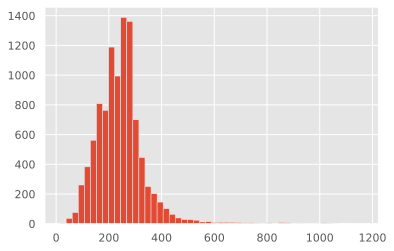

In [0]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
#Words tagged as B-NPI
data.loc[data['bio_tag'] == 'B-SYMP', 'Word'].count()

10993

In [0]:
#Words tagged as B-DI
data.loc[data['bio_tag'] == 'L-SYMP', 'Word'].count()

10993

In [0]:
data2=data[data['bio_tag']!='O']

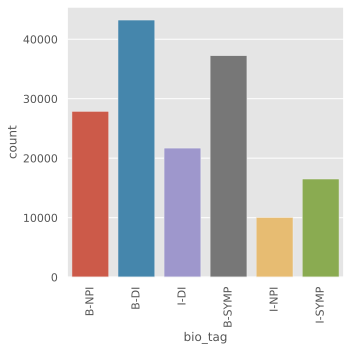

In [0]:
plt.figure(figsize=(5, 5))
ax = sns.countplot('bio_tag', data=data2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [0]:
#Simple feature map to feed arrays into the classifier. 
data['Word']=data['Word'].astype(str)
data['Sentence']=data['Sentence'].astype(str)
data['bio_tag']=data['bio_tag'].astype(str)
data['postag']=data['postag'].astype(str)




In [0]:
words = [feature_map(w) for w in data["Word"].tolist()]
tags = data["bio_tag"].values.tolist()

In [0]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

This is what word2features extracts:



In [0]:
X_train[0][1]

{'+1:postag': 'ADV',
 '+1:postag[:2]': 'AD',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'specifically',
 '-1:postag': 'NOUN',
 '-1:postag[:2]': 'NO',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'adjuvant',
 'bias': 1.0,
 'postag': 'NOUN',
 'postag[:2]': 'NO',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'treatments',
 'word[-2:]': 'ts',
 'word[-3:]': 'nts'}

In [0]:
%%time
crf = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)


CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 35.5 µs


In [0]:
%%time
crf.fit(X_train, y_train)

CPU times: user 4min 53s, sys: 378 ms, total: 4min 53s
Wall time: 4min 53s


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [0]:
%%time
pred = cross_val_predict(estimator=crf, X=X_test, y=y_test, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y_test)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


              precision    recall  f1-score   support

        B-DI       0.97      0.94      0.95      6020
       B-NPI       0.90      0.87      0.88      3004
      B-SYMP       0.98      0.96      0.97      3613
        I-DI       0.90      0.83      0.86      1126
       I-NPI       0.90      0.84      0.87       325
      I-SYMP       0.99      0.99      0.99      1769
        L-DI       0.97      0.94      0.96      6020
       L-NPI       0.90      0.87      0.89      3004
      L-SYMP       0.98      0.96      0.97      3613
           O       1.00      1.00      1.00    763100
        U-DI       0.98      0.96      0.97      8304
       U-NPI       0.98      0.96      0.97      6327
      U-SYMP       0.99      0.97      0.98      8578

    accuracy                           1.00    814803
   macro avg       0.96      0.93      0.94    814803
weighted avg       1.00      1.00      1.00    814803

CPU times: user 10min 8s, sys: 553 ms, total: 10min 8s
Wall time: 10min 8s


In [0]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
I-SYMP -> L-SYMP  4.406200
B-SYMP -> L-SYMP  4.361289
B-SYMP -> I-SYMP  4.252716
B-NPI  -> L-NPI   3.640697
B-DI   -> L-DI    3.291114
B-NPI  -> I-NPI   2.977500
I-NPI  -> L-NPI   2.965986
I-NPI  -> I-NPI   2.908594
O      -> O       2.907259
I-DI   -> L-DI    2.701321

Top unlikely transitions:
B-DI   -> U-SYMP  -5.711429
O      -> L-NPI   -5.752543
B-NPI  -> O       -5.955889
B-DI   -> O       -6.034374
O      -> I-SYMP  -6.087472
I-NPI  -> O       -6.244839
O      -> I-NPI   -6.262747
O      -> L-DI    -6.711904
I-DI   -> O       -6.788980
O      -> I-DI    -7.754943


In [0]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.363968 U-SYMP   word.lower():depression
12.238065 U-NPI    word.lower():plants
12.003434 U-DI     word.lower():obesity
11.812925 U-NPI    word.lower():walking
11.669628 U-SYMP   word.lower():inflammation
11.619743 U-SYMP   word.lower():vomiting
11.420888 U-DI     word.lower():adenomas
11.365011 U-NPI    word.lower():counseling
11.020793 U-NPI    word.lower():fasting
10.968106 U-SYMP   word.lower():fear
10.843460 U-NPI    word.lower():moxibustion
10.830854 U-NPI    word.lower():mindfulness
10.723262 U-SYMP   word.lower():lesion
10.715580 U-NPI    word.lower():isoflavones
10.666509 U-SYMP   word.lower():constipation
10.655897 U-NPI    word.lower():vitamins
10.655510 U-SYMP   word.lower():bleeding
10.639936 U-SYMP   word.lower():pain
10.613739 U-SYMP   word.lower():swelling
10.547975 U-DI     word.lower():face
10.401439 U-SYMP   word.lower():hypertension
10.285889 U-NPI    word.lower():writing
10.219751 U-SYMP   word.lower():stress
10.095891 U-SYMP   word.lower():confusio

**Evaluation**



In [0]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-DI',
 'L-DI',
 'U-SYMP',
 'B-SYMP',
 'I-SYMP',
 'L-SYMP',
 'U-DI',
 'B-NPI',
 'L-NPI',
 'U-NPI',
 'I-DI',
 'I-NPI']

In [0]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9698607552171392

In [0]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

        B-DI      0.971     0.961     0.966      6020
        I-DI      0.905     0.907     0.906      1126
        L-DI      0.977     0.967     0.972      6020
        U-DI      0.987     0.977     0.982      8304
       B-NPI      0.917     0.902     0.910      3004
       I-NPI      0.922     0.877     0.899       325
       L-NPI      0.918     0.903     0.911      3004
       U-NPI      0.985     0.983     0.984      6327
      B-SYMP      0.981     0.978     0.979      3613
      I-SYMP      0.987     0.996     0.992      1769
      L-SYMP      0.981     0.978     0.979      3613
      U-SYMP      0.994     0.986     0.990      8578

   micro avg      0.974     0.966     0.970     51703
   macro avg      0.960     0.951     0.956     51703
weighted avg      0.974     0.966     0.970     51703



**Hyperparameter tuning using Randomized CV Search**

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

In [0]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: ignored

Best result:



In [0]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [0]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

**Check best estimator on our test data**


As we can see, quality is improved.

In [0]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

**This is what classifier learned**

In [0]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(5))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-5:])

Top likely transitions:
B-DI   -> I-DI    4.986832
B-NPI  -> L-NPI   4.961998
B-NPI  -> I-NPI   3.996632
B-SYMP -> L-SYMP  3.589550
B-DI   -> L-DI    3.587632

Top unlikely transitions:
O      -> I-NPI   -6.210967
O      -> I-SYMP  -6.418849
I-NPI  -> O       -6.474338
I-DI   -> O       -6.586492
O      -> L-DI    -7.117975


In [0]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(50))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

In [0]:
# save the model to disk
filename = '/content/drive/My Drive/CRFModels/CRF10kAnnotation.sav'
joblib.dump(crf, filename)
#  the model from disk
#crf1 = joblib.load(filename)
#result = crf1.score(X_test, y_test)
#print(result)

In [0]:
eli5.show_weights(crf, top=30)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-DI,I-DI,L-DI,U-DI,B-NPI,I-NPI,L-NPI,U-NPI,B-SYMP,I-SYMP,L-SYMP,U-SYMP
O,2.907,1.012,-7.755,-6.712,0.748,0.801,-6.263,-5.753,1.097,0.886,-6.087,-4.976,1.203
B-DI,-6.034,-2.945,2.69,3.291,-4.433,-2.085,-1.88,-2.655,-3.374,-2.223,-2.277,-2.115,-5.711
I-DI,-6.789,-4.286,1.904,2.701,-4.917,-1.873,-1.426,-2.163,-2.662,-1.981,-1.694,-2.495,-4.345
L-DI,0.726,0.231,-3.376,-2.843,0.011,0.11,-1.073,-1.713,-0.304,-0.442,-1.675,-1.175,-0.802
U-DI,0.69,0.163,-4.42,-3.672,-0.415,-0.852,-1.987,-2.627,-1.002,-0.029,-2.494,-1.582,-0.769
B-NPI,-5.956,-1.424,-2.593,-2.042,-2.398,-2.098,2.978,3.641,-4.257,-1.553,-1.343,-1.502,-2.721
I-NPI,-6.245,-0.717,-1.123,-1.001,-2.146,-2.452,2.909,2.966,-3.769,-0.822,-0.273,-0.972,-2.772
L-NPI,0.677,-0.0,-1.498,-1.923,-0.785,-0.026,-1.483,-2.693,-1.078,-1.224,-0.215,-1.119,-1.591
U-NPI,0.866,-0.782,-2.363,-2.998,-1.425,-0.521,-4.645,-3.33,-0.313,0.016,-1.279,-2.003,-1.784
B-SYMP,-5.196,-1.494,-2.234,-2.805,-2.607,-1.329,-1.695,-1.725,-2.248,-2.465,4.253,4.361,-5.112


In [0]:
lemmatizer.lemmatize('counseling')

'counseling'

**Interpretation:**
Les modèles CRFsuite CRF utilisent deux types de fonctionnalités : des fonctionnalités d'état et des fonctionnalités de transition
Les caractéristiques de transition ont un sens : au moins le modèle a appris que **I-ENITITY** doit suivre **B-ENTITY**.
On peut s'attendre à ce que les transitions O -> I-ENTITY aient un poids négatif important car elles sont impossibles.
Nous pouvons également constater que **B-DI -> I-DI** a des poids positifs, ce qui est logique, car les noms des maladies sont parfois composés, il en va de même pour les INM.


In [0]:
eli5.show_weights(crf, top=10, feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Weight?,Feature
+0.667,word.istitle()
+0.607,word.isupper()
+0.581,word.isdigit()
Weight?,Feature
+0.627,word.istitle()
-0.934,word.isupper()
Weight?,Feature
+0.863,word.isdigit()
+0.134,word.isupper()
-0.555,word.istitle()


In [0]:
print("Sent:", sentences[26])
sent_f = sent2features(sentences[26])
print("Sent f shape:", len(sent_f), ", feats:", sent_f[15])
pred = crf.predict([sent_f])
print("Predicted:", pred)



# Annotate text




**Load crf model**

In [0]:
# save the model to disk
filename = '/content/drive/My Drive/CRFModels/CrfConclusion.sav'
#  the model from disk
crfC = joblib.load(filename)



Annotate text with B-ENTITY AND I-ENTITY

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
nltk.download('punkt')

Abstract='To examine the potential vitamin c and Diet Fad couple cup of green tea impact of elderly age on response to participation in a structured, multidisciplinary quality-of-life (QOL) intervention for patients with advanced cancer undergoing radiation therapy.'
text=word_tokenize(Abstract)
sentence =nltk.pos_tag(text)

list1=[]

Tagged_sent=""
#sent=""
print(sentence)
def pos_tag(sentence):
    sentence_features = [word2features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))

sentenceT= pos_tag(sentence)
print(sentenceT)
    
for index in range(len(sentence)):


  if sentenceT[index][1] in ['B-SYMP', 'B-DI', 'I-DI', 'B-NPI', 'I-NPI', 'I-SYMP']:

    Tagged_sent+= " "+sentenceT[index][0][0] +" ( "+sentenceT[index][1]+ " ) "
  else:

    Tagged_sent+=" "+sentenceT[index][0][0]
      
    list1.append(Tagged_sent)
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[('To', 'TO'), ('examine', 'VB'), ('the', 'DT'), ('potential', 'JJ'), ('vitamin', 'NN'), ('c', 'NN'), ('and', 'CC'), ('Diet', 'NNP'), ('Fad', 'NNP'), ('couple', 'JJ'), ('cup', 'NN'), ('of', 'IN'), ('green', 'JJ'), ('tea', 'JJ'), ('impact', 'NN'), ('of', 'IN'), ('elderly', 'JJ'), ('age', 'NN'), ('on', 'IN'), ('response', 'NN'), ('to', 'TO'), ('participation', 'NN'), ('in', 'IN'), ('a', 'DT'), ('structured', 'JJ'), (',', ','), ('multidisciplinary', 'JJ'), ('quality-of-life', 'NN'), ('(', '('), ('QOL', 'NNP'), (')', ')'), ('intervention', 'NN'), ('for', 'IN'), ('patients', 'NNS'), ('with', 'IN'), ('advanced', 'JJ'), ('cancer', 'NN'), ('undergoing', 'VBG'), ('radiation', 'NN'), ('therapy', 'NN'), ('.', '.')]
[(('To', 'TO'), 'O'), (('examine', 'VB'), 'O'), (('the', 'DT'), 'O'), (('potential', 'JJ'), 'O'), (('vitamin', 'NN'), 'B-NPI'), (('c', 'NN'), 'I-NPI'), (('and', 'CC'), 'O'), (

In [0]:
Tagged_sent

# Creating XML




**Loading Model**

In [0]:
crf_model_filename=""
Model_crf = joblib.load(crf_model_filename="")

In [0]:
def CRF_tag(sentence,crf):
    sentence_features = [word2features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))

**CreateXML is a function that annotate text with crf model and convert it to XML tags**

In [0]:
import re
### Only for IOB format
def CreateXML(Abstract,Model_crf):

  content = Abstract
  find=re.findall(r"[a-z0-9)%][.][A-Z]",content)

  if len(find)!=0:
      content=re.sub(r"([a-z0-9)%])[.]([A-Z])",r"\1. \2",content)
  #Tokenize the abstract
  text=word_tokenize(content)

  #Pos tag the abstract
  sentence =nltk.pos_tag(text)

  ## Tag the sentence with CRF
  sentenceT= CRF_tag(sentence,Model_crf)

  Tagged_sent=""

  ## For compound Tags eg. (B-NPI and I-NPI)
  compound=""


  for index in range(len(sentence)):


    
    if sentenceT[index][1] in ['B-SYMP', 'B-DI', 'B-NPI']:
      
      #if the I-ENTITY is followed with B-ENTITY
      if compound :
        Tagged_sent=Tagged_sent+compound+"</"+sentenceT[index-1][1][2:]+">"
        compound=""


      element = "<"+sentenceT[index][1][2:]+">"
      Tagged_sent+= element


      compound+=sentenceT[index][0][0]

      if not sentenceT[index+1][1] in ['I-SYMP', 'I-DI', 'I-NPI']:
            Tagged_sent+=sentenceT[index][0][0]+"</"+sentenceT[index][1][2:]+">"
            compound=""

    elif  sentenceT[index][1] in ['I-SYMP', 'I-DI', 'I-NPI']:

      compound+=" "+sentenceT[index][0][0]

    else:

      if compound :
        Tagged_sent=Tagged_sent+compound+"</"+sentenceT[index-1][1][2:]+">"
        compound=""


      Tagged_sent=Tagged_sent+ sentenceT[index][0][0]+" "
  
  return str(Tagged_sent)
      
  

In [0]:
Abstract='To examine the potential impact of elderly Physical health intervention age on Acoustic Stimulation Non Pharmacological Interventions and Play Therapy response to participation in a structured, multidisciplinary quality-of-life (QOL) intervention for patients with advanced cancer undergoing radiation therapy.'
Annotated_text=CreateXML(Abstract,crf)
Annotated_text

'To examine the potential impact of elderly Physical <NPI>health intervention</NPI>age on Acoustic Stimulation Non Pharmacological Interventions and Play Therapy response to participation in a structured , multidisciplinary quality-of-life ( QOL ) intervention for patients with advanced <DI>cancer</DI>undergoing radiation therapy . '

## Reading from XML and creating NER dataset

In [0]:
#invoke libraries
from bs4 import BeautifulSoup
from bs4.element import Tag
import codecs
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.model_selection import train_test_split
import pycrfsuite
import os, os.path, sys
import glob
from xml.etree import ElementTree
import numpy as np
from sklearn.metrics import classification_report

In [0]:
#this function appends all annotated files
def append_annotations(files):
    xml_files = glob.glob(files +"/*.xml")
    xml_element_tree = None
    new_data = ""
    for xml_file in xml_files:
        data = ElementTree.parse(xml_file).getroot()
        print (ElementTree.tostring(data) )       
        temp = ElementTree.tostring(data)
        new_data += (str(temp))
    return(new_data)

#this function removes special characters and punctuations
def remov_punct(withpunct):
    punctuations = '''!-[]{};:'"\,<>/?@#$%^&*_~'''
    without_punct = ""
    char = 'nan'
    for char in withpunct:
        if char not in punctuations:
            without_punct = without_punct + char
    return(without_punct)

# functions for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

def get_labels(doc):
    return [label for (token, postag, label) in doc]

In [0]:

#/content/drive/My Drive/Gate Annotation/Abstracts

files_path = "/content/drive/My Drive/Abstractttt/"

allxmlfiles = append_annotations(files_path)
soup = bs(allxmlfiles, "html5lib")

#identify the tagged element
docs = []
sents = []

for d in soup.find_all("paragraph"):
   for wrd in d.contents:    
    tags = []
    NoneType = type(None)   
    if isinstance(wrd.name, NoneType) == True:
        withoutpunct = remov_punct(wrd)
        temp = word_tokenize(str(withoutpunct))
        for token in temp:
            tags.append((token,'O'))            
    else:
        withoutpunct = remov_punct(wrd)
        temp = word_tokenize(str(withoutpunct))
        for token in temp:
            tags.append((token,(wrd.name).upper()))    
    sents = sents + tags 
   docs.append(sents) #appends all the individual documents into one list

In [0]:
docs[0]